# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
len(training.get_word_Xlengths('CHOCOLATE')[0]) # [17,20,12] is the length of each videos. thus there are 3 sample  of the word

49

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean() # there are 3 speakers in the training set
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x']) 
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std() 

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y']) 
asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x']) 
asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y']) 

asl.df['left-x-std']= asl.df['speaker'].map(df_std['left-x']) 
asl.df['left-y-std']= asl.df['speaker'].map(df_std['left-y']) 
asl.df['right-x-std']= asl.df['speaker'].map(df_std['right-x']) 
asl.df['right-y-std']= asl.df['speaker'].map(df_std['right-y']) 

In [12]:
asl.df['norm-rx'] = (asl.df['right-x']-asl.df['right-x-mean'])/asl.df['right-x-std']
asl.df['norm-ry'] = (asl.df['right-y']-asl.df['right-y-mean'])/asl.df['right-y-std']
asl.df['norm-lx'] = (asl.df['left-x']-asl.df['left-x-mean'])/asl.df['left-x-std']
asl.df['norm-ly'] = (asl.df['left-y']-asl.df['left-y-mean'])/asl.df['left-y-std']

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [13]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle
# relative to nose

asl.df['polar-rr'] = np.sqrt(asl.df['grnd-rx']**2 + asl.df['grnd-ry']**2)
asl.df['polar-rtheta'] =  np.arctan2(asl.df['grnd-rx'],asl.df['grnd-ry'])

asl.df['polar-lr'] = np.sqrt(asl.df['grnd-lx']**2 + asl.df['grnd-ly']**2)
asl.df['polar-ltheta'] =  np.arctan2(asl.df['grnd-lx'],asl.df['grnd-ly'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
# ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [14]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'
asl.df[['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']] = asl.df[['right-x','right-y','left-x','left-y']].diff(periods=1, axis=0)
asl.df[['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']] = asl.df[['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']].fillna(0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [15]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
# Rescale using min and max value (X-XMIN)/(XMAX-XMIN)
df_min = asl.df.groupby('speaker').min()
df_max = asl.df.groupby('speaker').max()

asl.df['left-x-min']= asl.df['speaker'].map(df_min['left-x']) 
asl.df['left-y-min']= asl.df['speaker'].map(df_min['left-y']) 
asl.df['right-x-min']= asl.df['speaker'].map(df_min['right-x']) 
asl.df['right-y-min']= asl.df['speaker'].map(df_min['right-y']) 

asl.df['left-x-max']= asl.df['speaker'].map(df_max['left-x']) 
asl.df['left-y-max']= asl.df['speaker'].map(df_max['left-y']) 
asl.df['right-x-max']= asl.df['speaker'].map(df_max['right-x']) 
asl.df['right-y-max']= asl.df['speaker'].map(df_max['right-y'])

asl.df['minmax-lx'] = (asl.df['left-x']-asl.df['left-x-min'])/(asl.df['left-x-max']-asl.df['left-x-min'])
asl.df['minmax-ly'] = (asl.df['left-y']-asl.df['left-y-min'])/(asl.df['left-y-max']-asl.df['left-y-min'])
asl.df['minmax-rx'] = (asl.df['right-x']-asl.df['right-x-min'])/(asl.df['right-x-max']-asl.df['right-x-min'])
asl.df['minmax-ry'] = (asl.df['right-y']-asl.df['right-y-min'])/(asl.df['right-y-max']-asl.df['right-y-min'])

# TODO define a list named 'features_custom' for building the training set
features_custom = ['minmax-rx', 'minmax-ry', 'minmax-lx', 'minmax-ly']

In [16]:
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...      right-x-min  right-y-min  \
video frame                               ...                                 
98    0          113        9      119    ...               94           37   
      1          113        9      119    ...               94           37   
      2          113        9      119    ...               94           37   
      3          113        9      119    ...               94           37   
      4          113        9      119    ...               94           37   

             left-x-max  left-y-max  right-x-max  right-y-max  minmax-lx  \
video frame                                                                
98    0             235         191          209          179   0.104167   
      1             235         191          209          179   0.104167   
      2             235         191          209          179   0.104167   
      3             235         191          209          179   0.104167   
      4             235         191          209          179   0.104167   

             minmax-ly  minmax-rx  minmax-ry  
video frame                                   
98    0       0.906542    0.66087   0.971831  
      1       0.906542    0.66087   0.971831  
      2       0.906542    0.66087   0.971831  
      3       0.906542    0.66087   0.971831  
      4       0.906542    0.66087   0.971831  

[5 rows x 43 columns]

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**
I used rescaled x, y value of both right and left hands, using min and max, and named the features as "minmax". By rescaling the coordinates, I am able to convert the original absolute number to a range of 0 to 1.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [17]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.017s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [18]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433223


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [19]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [20]:
# change word
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #1
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]

hidden state #2
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]

logL = -601.3291470028632


In [21]:
# change num of hidden state
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 5, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 5
hidden state #0
mean =  [  -6.37753172   51.09767101    3.64019095  104.46455217]
variance =  [  10.28279876   12.43850367   27.33782827  106.89825397]

hidden state #1
mean =  [  -7.70665738   93.36393433   12.99292645  127.06351815]
variance =  [ 29.53966949  13.52107768   0.66764483  48.4385572 ]

hidden state #2
mean =  [   3.32089022   86.11784619   12.66977977  102.36987409]
variance =  [ 12.48273231   7.43528515  12.86407411  24.73804616]

hidden state #3
mean =  [ -4.93673736  64.73126904   1.62601029  84.91542811]
variance =  [  6.16147276  28.36727822   5.4706657   13.12675543]

hidden state #4
mean =  [ -9.23826304  55.30740641   6.92298855  71.30558162]
variance =  [ 16.30897315  45.96991798   3.76848558  15.98402053]

logL = -544.2490114712278


In [22]:
# change num of hidden state and word
my_testword = 'BOOK'
model, logL = train_a_word(my_testword, 5, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 5
hidden state #0
mean =  [ -1.85154898  43.8565951   15.54791139  45.40701371]
variance =  [ 74.30738615  11.84593114  53.83661343  24.44684515]

hidden state #1
mean =  [-10.56457425  86.79928525  18.60263989  96.40046123]
variance =  [ 73.68657367  36.45553562  30.9764804   52.8761757 ]

hidden state #2
mean =  [ -4.59005588  55.38506358  12.97295613  56.66048692]
variance =  [ 28.13251996   6.74496379  26.35300906   8.0199002 ]

hidden state #3
mean =  [ -1.30983257  69.26376221  16.78709807  77.25705321]
variance =  [ 20.16932349  16.85869723  31.13211209  16.26925619]

hidden state #4
mean =  [ -13.93685025  114.48566887   20.23888716  118.35288727]
variance =  [  79.2124888   105.01164798   12.68114208   90.3702284 ]

logL = -2156.4141653741344


In [23]:
# change feature set
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_norm) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ 1.0625066  -0.1740204  -1.31812255 -1.61791893]
variance =  [ 0.05296979  0.00373254  0.03820247  0.05531266]

hidden state #1
mean =  [ 0.53813142 -0.04704542  0.04545    -0.61902479]
variance =  [ 0.02432711  0.04933945  0.03044391  0.13395751]

hidden state #2
mean =  [ 0.38934967 -0.18383814 -0.34623283 -1.59201968]
variance =  [ 0.0697732   0.02960059  0.07727065  0.06911305]

logL = 22.651977224475218


In [24]:
# change feature set
my_testword = 'BOOK'
model, logL = train_a_word(my_testword, 3, features_norm) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ 1.16050793 -0.3361429  -0.5022096  -2.22073513]
variance =  [ 0.13396219  0.03829545  0.45021762  0.11123555]

hidden state #1
mean =  [ 0.43609316 -0.22686509  0.39433383 -2.0344738 ]
variance =  [ 0.03713059  0.0184008   0.13829084  0.0787966 ]

hidden state #2
mean =  [ 0.55254803  0.1782496  -0.34612882 -1.39504558]
variance =  [ 0.06906066  0.08221395  0.07482992  0.11132208]

logL = -130.7108922194027


In [25]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_polar) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [  8.81313612e+01   8.31771967e-03   1.09304329e+02   1.18434797e-01]
variance =  [  2.06973439e+01   5.41190376e-03   1.41647879e+02   1.92144403e-03]

hidden state #1
mean =  [  6.05010053e+01  -9.31757873e-02   9.14166393e+01   2.57297227e-02]
variance =  [  6.15523307e+01   3.56540651e-03   1.30626433e+02   1.81995354e-03]

hidden state #2
mean =  [ 56.19235087  -0.16348589  71.60640024   0.0958256 ]
variance =  [  5.16348282e+01   4.22849414e-03   1.74535632e+01   1.18341913e-03]

logL = -179.21522065553492


In [26]:
my_testword = 'BOOK'
model, logL = train_a_word(my_testword, 3, features_polar) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ 51.27686638  -0.06610183  54.24221076   0.26241587]
variance =  [  3.91108870e+01   2.23340979e-02   4.74169364e+01   1.38546237e-02]

hidden state #1
mean =  [  95.22471724   -0.1218251   104.13967321    0.18651723]
variance =  [  2.03481049e+02   8.93230349e-03   1.49720059e+02   3.33260104e-03]

hidden state #2
mean =  [  6.95931464e+01  -1.73838692e-02   7.96640717e+01   2.14622648e-01]
variance =  [  1.63195285e+01   4.81721955e-03   1.46003715e+01   4.64076230e-03]

logL = -901.0844114013495


In [27]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ 0.58898126  0.51112137  0.30828181  0.65056011]
variance =  [ 0.00136108  0.00862538  0.00426699  0.00671331]

hidden state #1
mean =  [ 0.57727465  0.43921199  0.35881784  0.36012619]
variance =  [ 0.00202126  0.00206067  0.00116108  0.00232031]

hidden state #2
mean =  [ 0.62136554  0.5494486   0.30898237  0.50136105]
variance =  [ 0.0043365   0.00155707  0.00128584  0.00122282]

logL = 341.64148975592144


In [28]:
my_testword = 'BOOK'
model, logL = train_a_word(my_testword, 3, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ 0.65677139  0.55421214  0.40990827  0.47601836]
variance =  [ 0.00246841  0.00487769  0.00125312  0.00687119]

hidden state #1
mean =  [ 0.57156334  0.49336091  0.37225511  0.25513349]
variance =  [ 0.00130398  0.00210119  0.00186074  0.00226168]

hidden state #2
mean =  [ 0.65741392  0.39690537  0.46058882  0.20340834]
variance =  [ 0.00710198  0.00101435  0.00612318  0.00359716]

logL = 1069.5204432929888


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [29]:
%matplotlib inline

In [30]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()

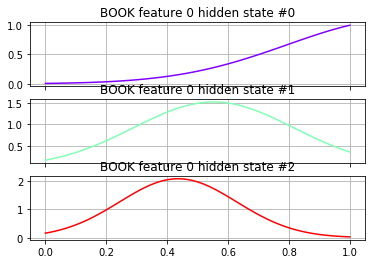

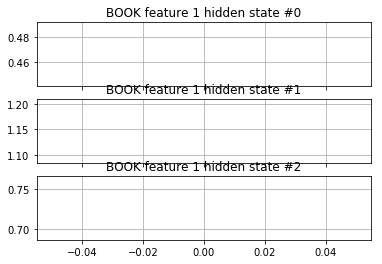

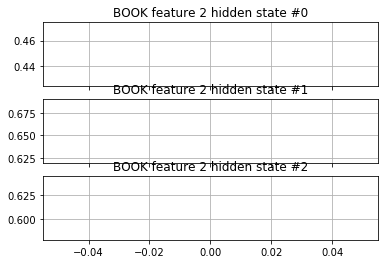

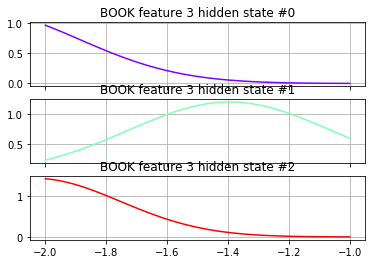

In [31]:
my_testword = 'BOOK'
model, logL = train_a_word(my_testword, 3, features_norm)
visualize(my_testword, model)

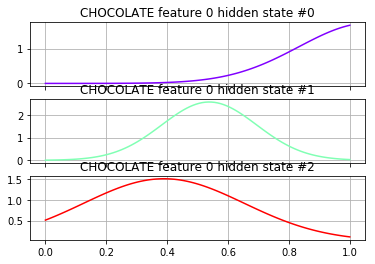

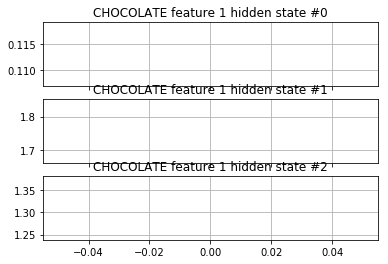

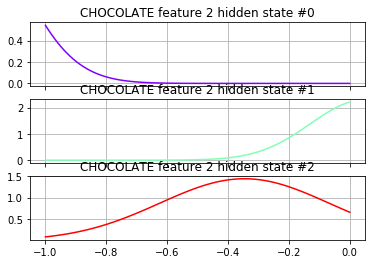

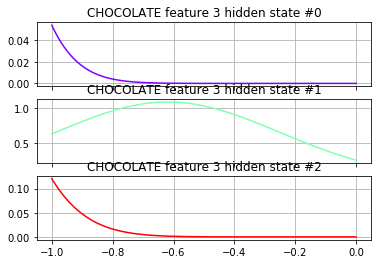

In [32]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_norm)
visualize(my_testword, model)

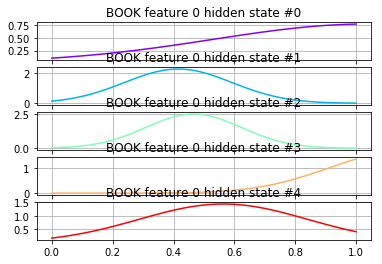

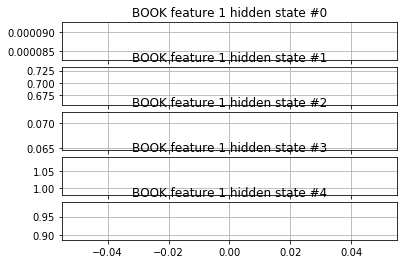

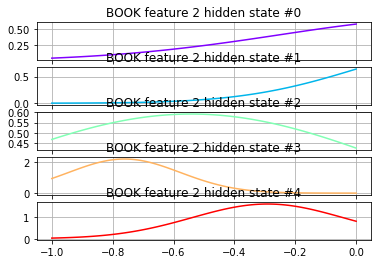

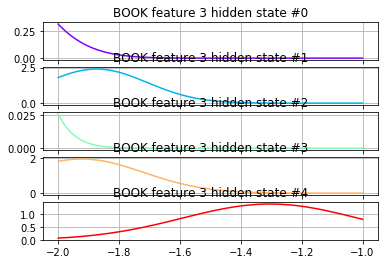

In [33]:
my_testword = 'BOOK'
model, logL = train_a_word(my_testword, 5, features_norm) 
visualize(my_testword, model)

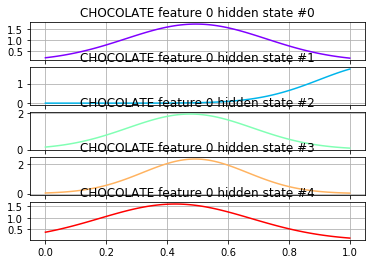

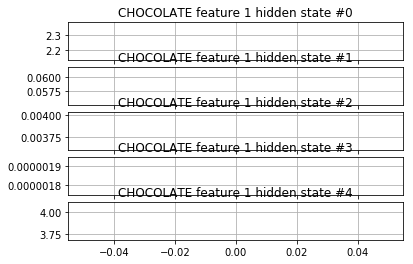

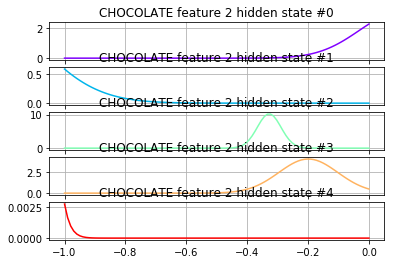

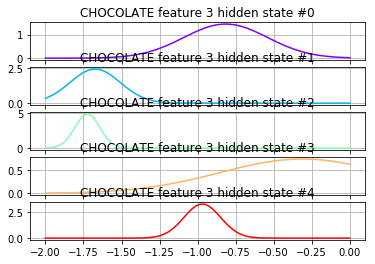

In [34]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 5, features_norm)
visualize(my_testword, model)

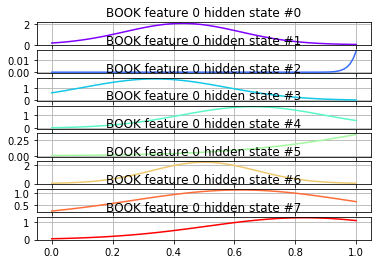

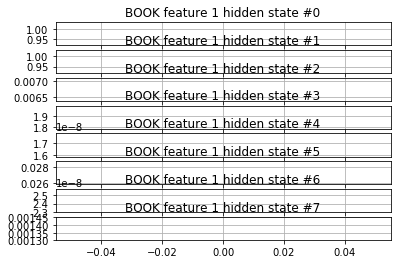

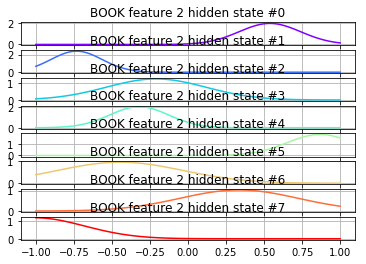

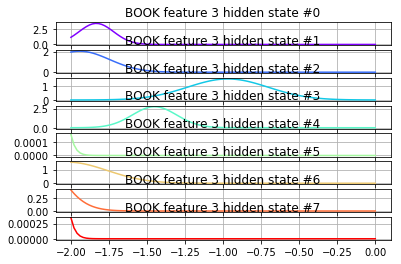

In [35]:
my_testword = 'BOOK'
model, logL = train_a_word(my_testword, 8, features_norm)
visualize(my_testword, model)

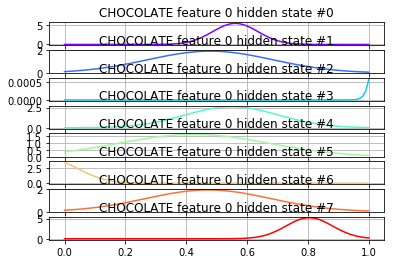

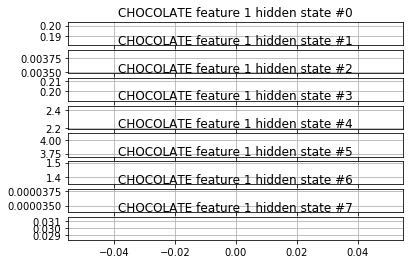

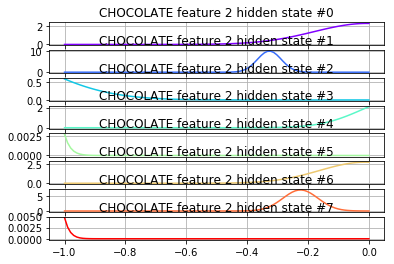

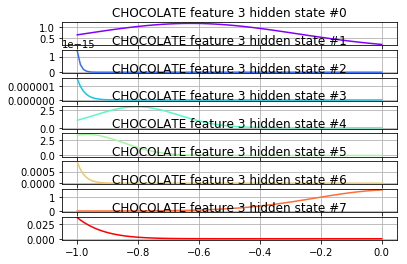

In [36]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 8, features_norm)
visualize(my_testword, model)

Number of hidden states seems to affect the shape of Gaussian distribution of each features at each state. 3 appears to be too few states, and the curve looks very wide compared with 5 or 8 states. 

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [37]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [38]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [39]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [40]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [41]:
from my_model_selectors import SelectorConstant
from my_model_selectors import SelectorCV
from my_model_selectors import SelectorBIC
from my_model_selectors import SelectorDIC

In [42]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

C:\Anaconda3\envs\aind\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Anaconda3\envs\aind\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training complete for FISH with 11 states with time 0.5005630321824769 seconds
Training complete for BOOK with 6 states with time 4.215033392250457 seconds


C:\Anaconda3\envs\aind\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Anaconda3\envs\aind\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training complete for VEGETABLE with 2 states with time 1.9720036216231307 seconds
Training complete for FUTURE with 2 states with time 4.41916503177259 seconds
Training complete for JOHN with 10 states with time 42.852796350409676 seconds


In [43]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.4406211923966481 seconds
Training complete for BOOK with 9 states with time 2.556414670075327 seconds
Training complete for VEGETABLE with 8 states with time 0.9188723704985904 seconds
Training complete for FUTURE with 5 states with time 2.490820057736869 seconds
Training complete for JOHN with 11 states with time 28.266708232585685 seconds


In [44]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 21.220194173138097 seconds
Training complete for BOOK with 13 states with time 113.52256538694311 seconds
Training complete for VEGETABLE with 14 states with time 103.52255031288297 seconds
Training complete for FUTURE with 14 states with time 113.22334721750491 seconds
Training complete for JOHN with 15 states with time 113.70081326158083 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**
1. Run time:
    - DIC is the slowest selector. It iterates all words and all possible number of states, with a time complexity of O(mn), m is the number of all words, and n is the number of possible states
    - BIC is the fastest selector. It calculates logL for each possible number of states, and computes number of parameters using number of hidden states, and number of features. The calculation of BIC parameter has a time O(1) and thus the overall run time is O(n), n is the number of possible states. 
    - Cross validation is in betweem regarding run time. For each possible number of states, it has a KFold cross validation, thus the run time is roughly linearly proportional to the n_splits although it may take shorter time to fit the model since we split the data in train and test. Overall, CV has about twice longer run time than BIC.  
2. Result:
    - 3 selectors produce different results (number of states). CV: 11-6-2-2-10, BIC: 5-9-9-5-14, DIC: 5-15-15-15-15
    - BIC penalizes for the number of states, therefore, it tends to produce smaller state number than DIC.
    - DIC caputures the difference between this_word and other words, and therefore, it may produce more complex HMM typology and use more states to represent.
    - CV depends a lot on the sample size since it needs to split the sample into train and test. If the sample size is small, like in the case of 'FISH', there may not be enough data to train the model and the result may not be accurate. 
    - BIC and DIC, on the contrary, use the whole sample from this_word to train the model.
3. Penalty:
    - BIC penalizes for the number of states (with N, n_features kept unchanged). The more states there are, the less preferred in general. This considers the topology of the HMM and balance complexity and overfitting
    - DIC computes the difference in likelihood between this word and other words. It seems to be a very comprehensive approach since maximization of the difference allows us to distinguish words the best. The down side is run time tends to be quite long. 

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [45]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 145.699s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [46]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [47]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [48]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [49]:
# TODO Choose a feature set and model selector
features = features_ground # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6685393258426966
Total correct: 59 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *ARRIVE                                             JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *GO1 *IX CAN                                   JOHN CAN GO CAN
   12: JOHN *HAVE *WHAT CAN                                          JOHN CAN GO CAN
   21: JOHN *HOMEWORK *NEW *PREFER *CAR *CAR *FUTURE *EAT            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   28: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   30: *SHOULD LIKE *GO *GO *GO                                      JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *YESTERDAY *GIVE *MARY *MARY                 MARY VEGETABLE KNOW IX LIKE CORN1
   40: *SUE *GIVE *CORN *VEGETABLE *GO                               JOHN IX THINK MARY LOVE
   43: *FRANK *GO BUY HOUSE         

### Try different feature set and model selector

In [50]:
# TODO Choose a feature set and model selector
features = features_polar# change as needed
model_selector = SelectorBIC# change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.550561797752809
Total correct: 80 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *NEW                                                JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO *ARRIVE                                       JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: JOHN *NEW WONT *WHO *GIVE1 *TEACHER *FUTURE *WHO              JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *FUTURE *WHO IX                                     JOHN LIKE IX IX IX
   28: JOHN *WHO *FUTURE *WHO IX                                     JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *GIRL *GIVE *MARY *MARY                      MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *FUTURE1 *JOHN *MARY                              JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE        

In [51]:
# TODO Choose a feature set and model selector
features = features_custom# change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5898876404494382
Total correct: 73 out of 178
Video  Recognized                                                    Correct
    2: *POSS WRITE HOMEWORK                                          JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE *MARY *TOY                                       JOHN CAN GO CAN
   12: *CAR *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: *ANN FISH *HOMEWORK *ANN *BLAME *BLAME *CHICKEN *EAT          JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN LIKE *ANN *LIKE *ANN                                     JOHN LIKE IX IX IX
   28: *ANN LIKE *ANN *LIKE *ANN                                     JOHN LIKE IX IX IX
   30: *IX LIKE *MARY *LIKE IX                                       JOHN LIKE IX IX IX
   36: MARY *JOHN *GIVE1 *VISIT *FRANK *IX                           MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *FRANK *SELF *VEGETABLE *MARY                            JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

In [52]:
# TODO Choose a feature set and model selector
features = features_delta# change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6235955056179775
Total correct: 67 out of 178
Video  Recognized                                                    Correct
    2: JOHN *GIVE1 HOMEWORK                                          JOHN WRITE HOMEWORK
    7: JOHN *STUDENT *GIVE1 *ARRIVE                                  JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: JOHN *WHAT WONT *WHAT *BUY *BLAME *MARY *WHAT                 JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *JOHN IX IX                                        JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX *SHOULD                                   JOHN LIKE IX IX IX
   30: JOHN *IX IX *JOHN IX                                          JOHN LIKE IX IX IX
   36: *JOHN *JOHN *JOHN IX *JOHN *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *JOHN MARY *MARY                                      JOHN IX THINK MARY LOVE
   43: JOHN *IX *FINISH HOUSE       

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**
- Based on different combinations, I find the following 3 combinations have low WER
    - polar feature + BIC selector: WER 0.55
    - minmax rescale feature + BIC selector: WER 0.59
    - delta feature + BIC selector: WER 0.62
- The best combination is polar and BIC selector. Polar features perform better than others because it not only captures the relative distance of both hands to nose, but also records the radius angle, which allows for better distinction among words. CV selector is limited by sample size. If sample size is too little, split will not work. DIC selector runs very slowly. I choose to use BIC selector which is not only fast, but also performs well. 
- To further improve WER, each word has a certain probability that it is adjacent to specific other words using context training and statistical grammar. We can use this additional information to make better choices.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [53]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 34.624s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>